Tenemos un dataset con datos históricos de varias variables promediadas en valores diarios de 6 los últimos 6 años.

Se tiene el siguiente diccionario de datos:
- La columna de índice es la fecha.
- PresionAire: es la presión del aire en milibars
- PresionVapor: es la presión del vapor de agua en el aire en milibars
- Humedadrelativa: es el porcentaje de humedad relativa
- ConcentracionVapor: es la concentración del vapor de agua en mmol/mol
- DensidadAire: es la densidad del aire en g/metros cúbicos
- DireccionViento: es la dirección del viento en grados
- Temperatura: es la temperatura en grados centigrados

In [45]:
# cargamos las librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D

In [46]:
from keras.layers import LSTM

In [47]:
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSFa9gjOa3NgXlS-hRN9SgOYCEFjuuYvZVbwEjF9f757qiIOBcNXwKse_CZcot1Nw/pub?gid=1224452159&single=true&output=csv'

In [48]:
df = pd.read_csv(link)

In [49]:
df.head()

,Fecha,PresionAire (mbar),PresionVapor (mbar),HumedadRelativa (%),ConcentracionVapor (mmol/mol),DensidadAire (g/m**3),DireccionViento (grado),Temperatura (C)
0,01.01.2010,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,02.01.2010,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,03.01.2010,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,04.01.2010,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,05.01.2010,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736


In [50]:
# conocer la cantidad de filas del df
df.shape

(2193, 8)

Ploteamos temperatura

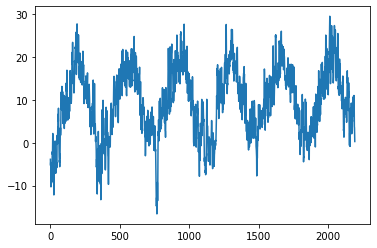

In [51]:
# iloc[filas,columnas]
df.iloc[:,-1].plot()

In [52]:
# verificamos los tipos de dato
df.dtypes

Fecha                             object
PresionAire (mbar)               float64
PresionVapor (mbar)              float64
HumedadRelativa (%)              float64
ConcentracionVapor (mmol/mol)    float64
DensidadAire (g/m**3)            float64
DireccionViento (grado)          float64
Temperatura (C)                  float64
dtype: object

In [53]:
# convertimos la variable fecha a formato fecha

df['Fecha'] = pd.to_datetime(df['Fecha'])
df.dtypes

Fecha                            datetime64[ns]
PresionAire (mbar)                      float64
PresionVapor (mbar)                     float64
HumedadRelativa (%)                     float64
ConcentracionVapor (mmol/mol)           float64
DensidadAire (g/m**3)                   float64
DireccionViento (grado)                 float64
Temperatura (C)                         float64
dtype: object

In [54]:
# selecciono la variable de interés y se transforma fecha a índice

df = df[['Fecha','Temperatura (C)']].set_index('Fecha')
df.head()

,Temperatura (C)
Fecha,
2010-01-01,-3.863403
2010-02-01,-5.296667
2010-03-01,-4.605903
2010-04-01,-6.284306
2010-05-01,-10.286736


In [55]:
# agrupar la temperatura de dia a mes

meses = df.resample('M').mean()
meses.head()

,Temperatura (C)
Fecha,
2010-01-31,1.113461
2010-02-28,3.461329
2010-03-31,7.917014
2010-04-30,8.746801
2010-05-31,9.698203


In [56]:
meses.shape

(72, 1)

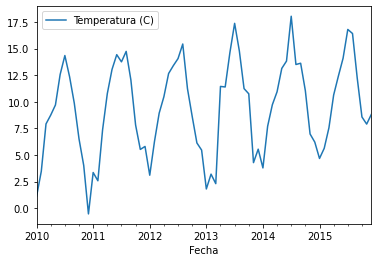

In [57]:
meses.plot()

Modelos LSTM

In [58]:
# verifico las dimensiones del dataset

dataset = meses.values
len(dataset)

72

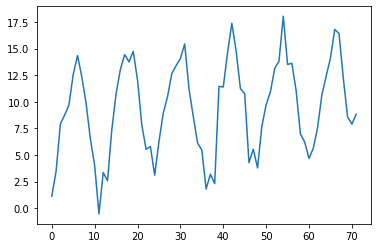

In [59]:
# grafica de la variable presión mbar en el tiempo
# reshape(-1,1) es transformar a vector columna

dataset = dataset.reshape(-1,1)
plt.plot(dataset)

Escalamiento

In [60]:
# min_max scaler

# escalando datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

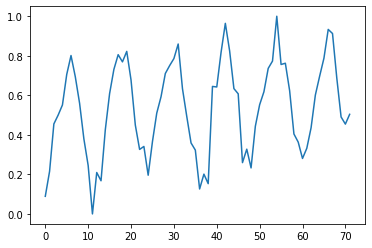

In [61]:
# visualizamos datos escalados (verificamos escalamiento)
dataset = dataset.reshape(-1,1)
plt.plot(dataset)

Partición train test

In [62]:
# train_test_split
test_size = 15
train_size = len(dataset) - test_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train_size,test_size)

57 15


Crear la función que transforma de vector columna a matriz

In [63]:
# convertimos serie a array

def to_sequences(dataset, seq_size = 1):
    x=[]
    y=[]
    
    for i in range(len(dataset) - seq_size-1):
        window = dataset[i:(i+seq_size),0]
        x.append(window)
        y.append(dataset[i+seq_size,0])
    
    return np.array(x),np.array(y)

Utilizar la función creada en la linea anterior

In [64]:
seq_size = 12 # hace referencia al número de predictores (input de la rn)

trainX, trainY = to_sequences(train,seq_size)
testX, testY = to_sequences(test,seq_size)

In [65]:
# Verificamos las nuevas dimensiones de train y test

print(trainX.shape)
print(testX.shape)

(44, 12)
(2, 12)


Transformamos a tensores (restricción que pide las librerias LSTM)

In [66]:
# redimensionando los inputs para la RNR
# como la serie temporal es univariable, entonces features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

print(trainX.shape, testX.shape)

(44, 12, 1) (2, 12, 1)


RED LSTM

In [67]:
# Creando la red neuronal
# input_shape (columnas, características)
# define model

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Entrenamiento de la red

In [68]:
EPOCHS = 100
BS = seq_size

history = model.fit(trainX,trainY,epochs=EPOCHS,validation_data=(testX,testY), verbose = 1, batch_size= BS)

Epoch 1/100
4/4 [==============================] - 2s 122ms/step - loss: 0.3799 - val_loss: 0.2056
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 0.3159 - val_loss: 0.1438
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2574 - val_loss: 0.0898
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2003 - val_loss: 0.0455
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1459 - val_loss: 0.0139
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0983 - val_loss: 2.9025e-04
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0626 - val_loss: 0.0214
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0606 - val_loss: 0.0670
Epoch 9/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0675 - val_loss: 0.0502
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0594 - val_loss: 0.0191
Epoch 11/100
4

Text(0.5, 1.0, 'ECM vs. epochs')

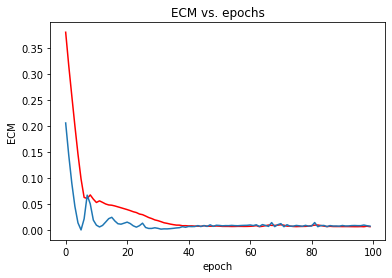

In [69]:
# ECM error cuadrático medio

plt.plot(history.history['loss'],color = 'r')
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('ECM')
plt.title('ECM vs. epochs')

In [70]:
# predicciones escaladas

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# predicciones de datos originales de °C (escala original)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [71]:
# metricas rmse

(mean_squared_error(testY,testPredict))**0.5

7.249927651932256

In [72]:
# vectores a graficar

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

# shift test predictions 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1:] = testPredict


<function matplotlib.pyplot.show>

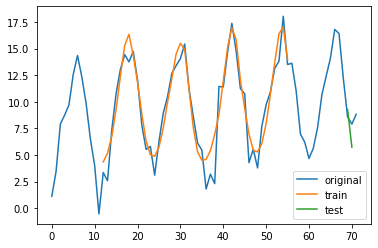

In [73]:
# ploteo los vectores definidos en la celda anterior

plt.plot(scaler.inverse_transform(dataset), label ='original')
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot,label = 'test')
plt.legend(loc = 'best')
plt.show

Pronóstico

In [74]:
# data de test
# 1 es porque la serie es univariante
testX.shape

(2, 12, 1)

In [75]:
# el último registro de la data de test

testX, testY = to_sequences(test,seq_size)   # transformamos la data test a tabla
testX = testX[-1,:].reshape(-1,seq_size)      # redimensionar a forma de tensor
testX.shape

(1, 12)

In [76]:
# convierto a tensor 3D

x_test = testX.reshape((testX.shape[0], testX.shape[1],1))
x_test.shape

(1, 12, 1)

# Cantidad de puntos del pronóstico

In [77]:
# con esto lleno los huecos (np.nan) de la matriz para seguir calculando los días a futuro a predecir

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0] = nuevoValor
    return x_test

results = []
for i in range(12):           # en esta fila, cambiar el valor de (24) para predecir los puntos deseados
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test,parcial[0])

[[[0.40437287]
  [0.3632074 ]
  [0.28054166]
  [0.33193588]
  [0.43580452]
  [0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]
  [0.49050054]]]
[[[0.3632074 ]
  [0.28054166]
  [0.33193588]
  [0.43580452]
  [0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]
  [0.49050054]
  [0.33771056]]]
[[[0.28054166]
  [0.33193588]
  [0.43580452]
  [0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]
  [0.49050054]
  [0.33771056]
  [0.27084512]]]
[[[0.33193588]
  [0.43580452]
  [0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]
  [0.49050054]
  [0.33771056]
  [0.27084512]
  [0.2766425 ]]]
[[[0.43580452]
  [0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]
  [0.49050054]
  [0.33771056]
  [0.27084512]
  [0.2766425 ]
  [0.33694845]]]
[[[0.6014809 ]
  [0.69694394]
  [0.7876848 ]
  [0.9333212 ]
  [0.912616  ]
  [0.68716776]


In [78]:
# valores inversos al escalado

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[ 5.73284914],
       [ 4.49068626],
       [ 4.59838461],
       [ 5.71869147],
       [ 7.5626182 ],
       [10.20100072],
       [13.42287147],
       [17.06642381],
       [19.19580364],
       [16.55407049],
       [11.57694721],
       [ 7.81558818],
       [ 5.05550687],
       [ 4.58806256],
       [ 5.26963407],
       [ 6.77977664],
       [ 9.14650718],
       [12.62394669],
       [17.10396941],
       [21.00517885],
       [21.81198634],
       [16.01630513],
       [10.06939512],
       [ 6.07588018]])

In [79]:
# verifico la cantidad de los valores a futuro pronosticados
y_pred = pd.DataFrame(inverted)
len(y_pred)

24

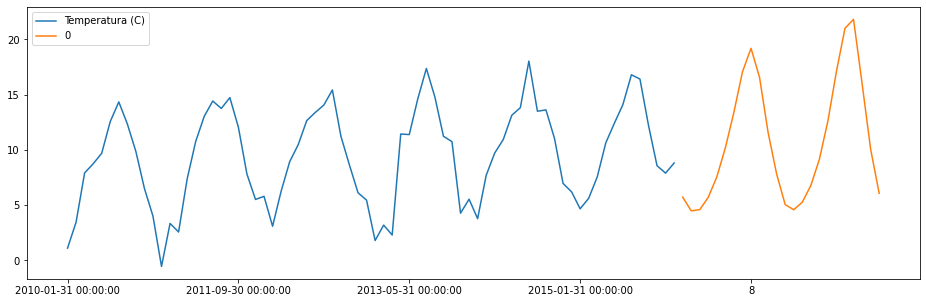

In [80]:
df2 = pd.concat([meses,y_pred])
df2.plot(figsize=(16,5))